# Trends in anomalies using clustering analysis of explanation weights

In [1]:
import os
# Set environment variables to disable multithreading
# as users will probably want to set the number of cores
# to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra import clustering
from sdss.metadata import MetaData

meta = MetaData()

# Custom functions

# Data ingestion

In [3]:
bin_id = "bin_03"
phd_dir = "/home/elom/phd"
spectra_dir = f"{phd_dir}/00_phd_code/spectra"
explanations_dir = f"{phd_dir}/00_phd_code/explanations"
paper_figures_dir = f"{phd_dir}/00_paper_explain-me-why/sections/figures/"
wave = np.load(f"{spectra_dir}/wave_spectra_imputed.npy")


# MSE
From previous analysis we determined the number of clusters is 5

In [ ]:
score_name = "mse_noRel100"
explanation_run_id = "20250427190650_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)
norm_abs_weights = np.abs(weights)
norm_abs_weights /= np.max(norm_abs_weights, axis=1, keepdims=True)

## Clustering using unique explanation weights

In [11]:
X = clustering.get_weights_per_segments(
    weights=norm_abs_weights, n_segments=128,
)

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()
print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=norm_abs_weights,
    print_n_clusters=True
)

(
    _, unique_weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=False
)

centroids = kmeans.cluster_centers_

# get closest spectra to each centroid
n_closest = 12
idx_closest_to_centroid = {}
for label, cluster in unique_weights_cluster_dict.items():

    cluster_centroid = centroids[label].reshape(1, -1)

    distances = np.sum((cluster - cluster_centroid)**2, axis=1)

    idx_closest = np.argsort(distances)[:n_closest]

    idx_closest_to_centroid[int(label)] = idx_closest


Base size: 29, Residual size: 61
New number of segments: 129
train time: 0.05 seconds
Cluster: 0,N. spectra: 1993
Cluster: 1,N. spectra: 3704
Cluster: 2,N. spectra: 1603
Cluster: 3,N. spectra: 1759
Cluster: 4,N. spectra: 941


### Average spectrun and explantion weights per cluster

<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_88216/1191960453.py:42: SyntaxWarning: invalid escape sequence '\l'
  axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_88216/1191960453.py:43: SyntaxWarning: invalid escape sequence '\l'
  axs[4,1].set_xlabel("$\lambda$ [$\AA$]")


Text(0.5, 0, '$\\lambda$ [$\\AA$]')

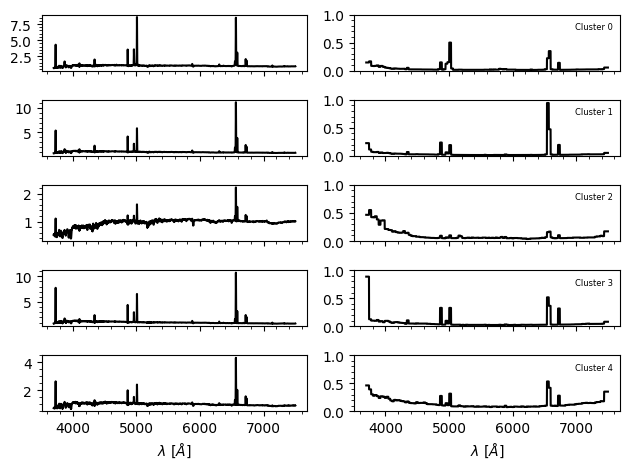

In [8]:
fig, axs = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_weights = cluster_weights.mean(axis=0)
    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 1].legend(
        [f"Cluster {label}"],
        fontsize=6,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 1].set_ylim(0., 1.)


axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
axs[4,1].set_xlabel("$\lambda$ [$\AA$]")

### Cluster 0

Cluster label: 0
Cluster centroid index: [ 941 1326  543   76 1598 1558  744 1057  616   59 1063  161]


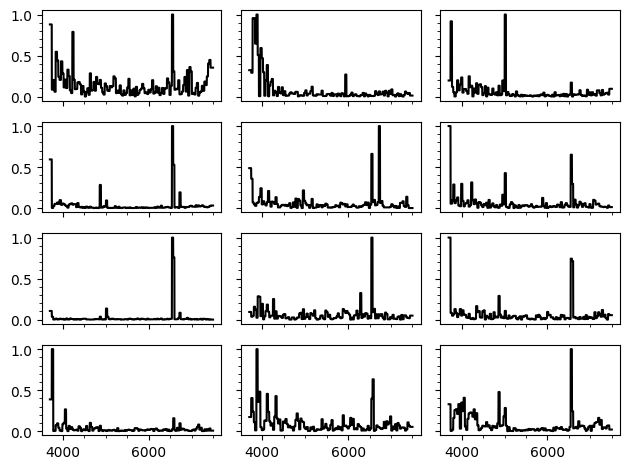

In [21]:
# better check, not sure if logic to get spectra is correct
label = 0
centroid_indexes = idx_closest_to_centroid[label]
print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

n_rows, n_cols = 4, 3
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid
centroid_indexes_reshaped = centroid_indexes.reshape(n_rows, n_cols)

for i, row_centroids_indexes in enumerate(centroid_indexes_reshaped):
    for j, centroid_index in enumerate(row_centroids_indexes):
        # axs[i, j].plot(
            # wave, anomalies_array[centroid_index],
            # color="black",
        # )
        axs[i, j].plot(
            wave, norm_abs_weights[centroid_index],
            color="black",
        )

    # spectrum = spectra_cluster_dict[label][centroid_index]
    # axs[i//3, i%3].plot(wave, spectrum, color="black")
    # print(i//3, i%3)
    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


## Cluster all explanation weights

<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_88216/3768913705.py:65: SyntaxWarning: invalid escape sequence '\l'
  axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_88216/3768913705.py:66: SyntaxWarning: invalid escape sequence '\l'
  axs[4,1].set_xlabel("$\lambda$ [$\AA$]")


train time: 0.84 seconds
Cluster: 0,N. spectra: 1760
Cluster: 1,N. spectra: 4168
Cluster: 2,N. spectra: 1926
Cluster: 3,N. spectra: 1336
Cluster: 4,N. spectra: 810


Text(0.5, 0.98, 'Mean spectra and explanation weights (mse_noRel100)')

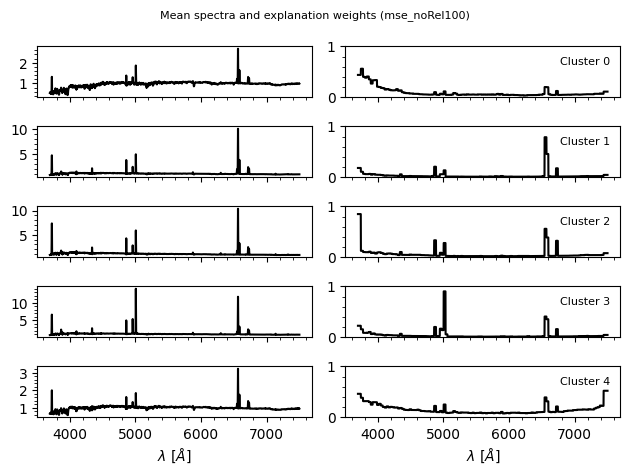

In [22]:
X = norm_abs_weights

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()

print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=True
)

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    avg_weights = cluster_weights.mean(axis=0)
    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 1].legend(
        [f"Cluster {label}"],
        fontsize=8,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 1].set_ylim(0., 1.)
# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
axs[4,1].set_xlabel("$\lambda$ [$\AA$]")
fig.suptitle(
    "Mean spectra and explanation weights "
    f"({score_name})",
    fontsize=8,
    # y=0.95
)
# axs[0].set_ylim(0., 1.)

### Plot centroids

<>:94: SyntaxWarning: invalid escape sequence '\l'
<>:95: SyntaxWarning: invalid escape sequence '\l'
<>:96: SyntaxWarning: invalid escape sequence '\l'
<>:94: SyntaxWarning: invalid escape sequence '\l'
<>:95: SyntaxWarning: invalid escape sequence '\l'
<>:96: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/693911366.py:94: SyntaxWarning: invalid escape sequence '\l'
  axs[4, 0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_54052/693911366.py:95: SyntaxWarning: invalid escape sequence '\l'
  axs[4, 1].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_54052/693911366.py:96: SyntaxWarning: invalid escape sequence '\l'
  axs[4, 2].set_xlabel("$\lambda$ [$\AA$]")


train time: 0.91 seconds
Cluster: 0,N. spectra: 1760
Cluster: 1,N. spectra: 4168
Cluster: 2,N. spectra: 1926
Cluster: 3,N. spectra: 1336
Cluster: 4,N. spectra: 810


Text(0.5, 0, '$\\lambda$ [$\\AA$]')

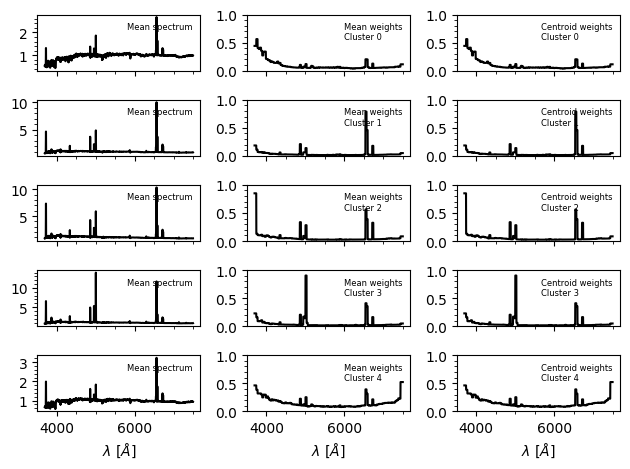

In [61]:
X = norm_abs_weights

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()

print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=True
)

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=5,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid
centroids_all = kmeans.cluster_centers_

for label, centroid in enumerate(centroids_all):

    # spectra
    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )

    axs[label, 0].legend(
        ["Mean spectrum"],
        fontsize=6,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    # weights
    avg_weights = weights_cluster_dict[label].mean(axis=0)

    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
    )

    axs[label, 1].legend(
        [f"Mean weights\nCluster {label}"],
        fontsize=6,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 1].set_ylim(0., 1.)

    # centroid
    axs[label, 2].plot(
        wave, centroid,
        color="black",
    )

    axs[label, 2].legend(
        [f"Centroid weights\nCluster {label}"],
        fontsize=6,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 2].set_ylim(0., 1.)


# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[4, 0].set_xlabel("$\lambda$ [$\AA$]")
axs[4, 1].set_xlabel("$\lambda$ [$\AA$]")
axs[4, 2].set_xlabel("$\lambda$ [$\AA$]")
# fig.suptitle(
#     "Mean spectra and weights centroids "
#     f"({score_name})",
#     fontsize=10,
#     # y=0.95
# )
# axs[0].set_ylim(0., 1.)

#### Average spectra of cluster 0

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/388430813.py:22: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [\AA]")


Text(0.5, 0, '$\\lambda$ [\\AA]')

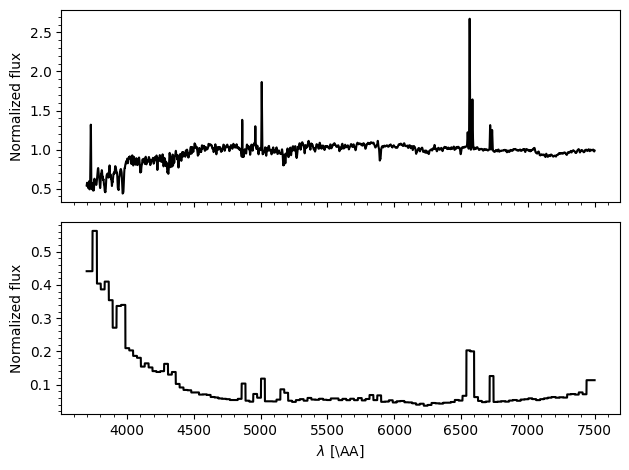

In [31]:
label = 0
centroid = kmeans.cluster_centers_[label]
avg_spectrum = np.mean(spectra_cluster_dict[label], axis=0)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

axs[0].plot(wave, avg_spectrum, color="black")
axs[0].set_ylabel("Normalized flux")
# axs[0].set_xlabel("$\lambda$ [\AA]")
axs[1].plot(wave, centroid, color="black")
axs[1].set_ylabel("Normalized flux")
axs[1].set_xlabel("$\lambda$ [\AA]")


#### Average spectra of cluster 1

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/2157794956.py:22: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [\AA]")


Text(0.5, 0, '$\\lambda$ [\\AA]')

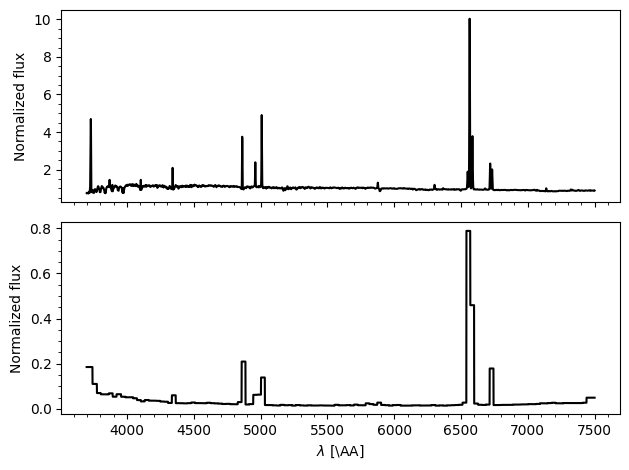

In [35]:
label = 1
centroid = kmeans.cluster_centers_[label]
avg_spectrum = np.mean(spectra_cluster_dict[label], axis=0)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

axs[0].plot(wave, avg_spectrum, color="black")
axs[0].set_ylabel("Normalized flux")
# axs[0].set_xlabel("$\lambda$ [\AA]")
axs[1].plot(wave, centroid, color="black")
axs[1].set_ylabel("Normalized flux")
axs[1].set_xlabel("$\lambda$ [\AA]")


#### Average spectra of cluster 2

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/3325888968.py:22: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [\AA]")


Text(0.5, 0, '$\\lambda$ [\\AA]')

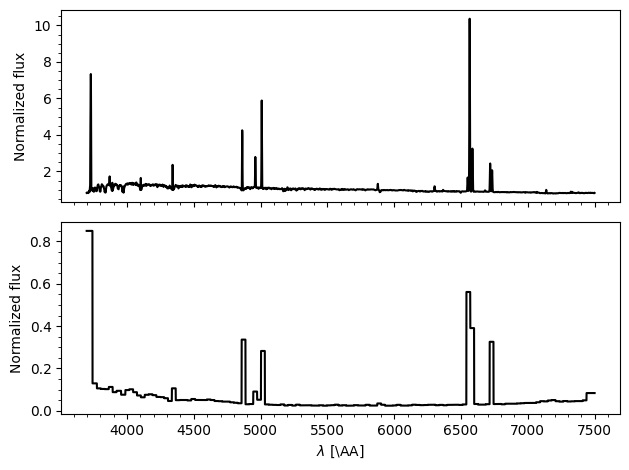

In [34]:
label = 2
centroid = kmeans.cluster_centers_[label]
avg_spectrum = np.mean(spectra_cluster_dict[label], axis=0)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

axs[0].plot(wave, avg_spectrum, color="black")
axs[0].set_ylabel("Normalized flux")
# axs[0].set_xlabel("$\lambda$ [\AA]")
axs[1].plot(wave, centroid, color="black")
axs[1].set_ylabel("Normalized flux")
axs[1].set_xlabel("$\lambda$ [\AA]")


#### Average spectra of cluster 3

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/2392232934.py:22: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [\AA]")


Text(0.5, 0, '$\\lambda$ [\\AA]')

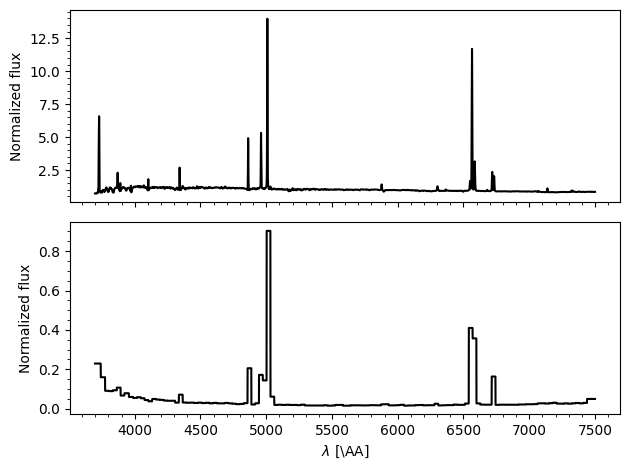

In [33]:
label = 3
centroid = kmeans.cluster_centers_[label]
avg_spectrum = np.mean(spectra_cluster_dict[label], axis=0)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

axs[0].plot(wave, avg_spectrum, color="black")
axs[0].set_ylabel("Normalized flux")
# axs[0].set_xlabel("$\lambda$ [\AA]")
axs[1].plot(wave, centroid, color="black")
axs[1].set_ylabel("Normalized flux")
axs[1].set_xlabel("$\lambda$ [\AA]")


#### Average spectra of cluster 4


<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/2716707447.py:22: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [\AA]")


Text(0.5, 0, '$\\lambda$ [\\AA]')

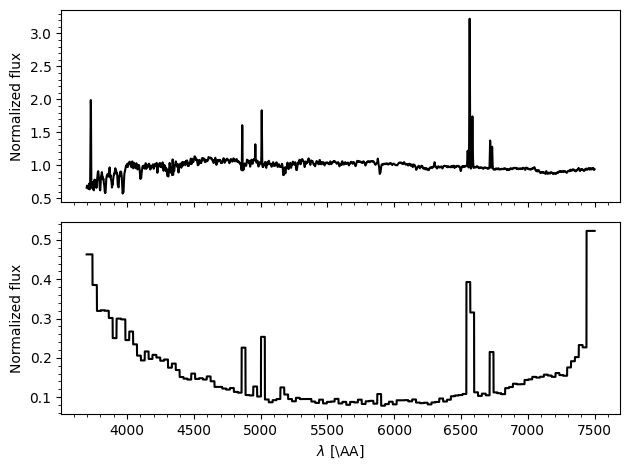

In [32]:
label = 4
centroid = kmeans.cluster_centers_[label]
avg_spectrum = np.mean(spectra_cluster_dict[label], axis=0)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

axs[0].plot(wave, avg_spectrum, color="black")
axs[0].set_ylabel("Normalized flux")
# axs[0].set_xlabel("$\lambda$ [\AA]")
axs[1].plot(wave, centroid, color="black")
axs[1].set_ylabel("Normalized flux")
axs[1].set_xlabel("$\lambda$ [\AA]")


#### closest spectra to centroids

# MSE noRel 97

In [24]:
score_name = "mse_noRel97"
explanation_run_id = "20250427151754_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)
norm_abs_weights = np.abs(weights)
norm_abs_weights /= np.max(norm_abs_weights, axis=1, keepdims=True)

<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_88216/3768913705.py:65: SyntaxWarning: invalid escape sequence '\l'
  axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_88216/3768913705.py:66: SyntaxWarning: invalid escape sequence '\l'
  axs[4,1].set_xlabel("$\lambda$ [$\AA$]")


train time: 1.38 seconds
Cluster: 0,N. spectra: 2275
Cluster: 1,N. spectra: 1871
Cluster: 2,N. spectra: 1597
Cluster: 3,N. spectra: 1829
Cluster: 4,N. spectra: 2428


Text(0.5, 0.98, 'Mean spectra and explanation weights (mse_noRel97)')

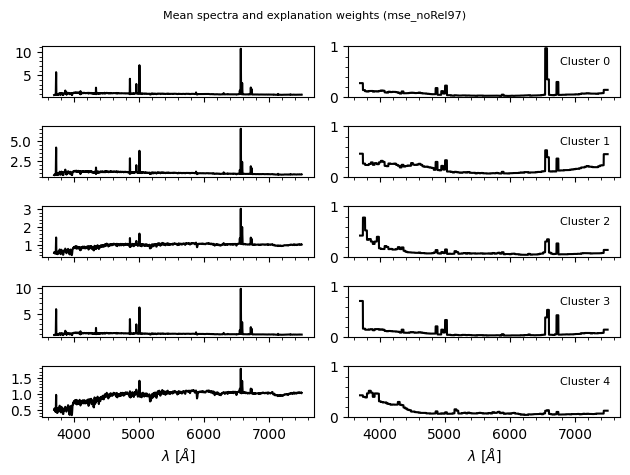

In [25]:
X = norm_abs_weights

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()

print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=True
)

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    avg_weights = cluster_weights.mean(axis=0)
    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 1].legend(
        [f"Cluster {label}"],
        fontsize=8,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 1].set_ylim(0., 1.)
# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
axs[4,1].set_xlabel("$\lambda$ [$\AA$]")
fig.suptitle(
    "Mean spectra and explanation weights "
    f"({score_name})",
    fontsize=8,
    # y=0.95
)
# axs[0].set_ylim(0., 1.)

# MSE filter 250 kms noRel100

In [26]:
score_name = "mse_filter_250kms_noRel100"
explanation_run_id = "20250427094150_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)
norm_abs_weights = np.abs(weights)
norm_abs_weights /= np.max(norm_abs_weights, axis=1, keepdims=True)

<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_88216/3768913705.py:65: SyntaxWarning: invalid escape sequence '\l'
  axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_88216/3768913705.py:66: SyntaxWarning: invalid escape sequence '\l'
  axs[4,1].set_xlabel("$\lambda$ [$\AA$]")


train time: 0.93 seconds
Cluster: 0,N. spectra: 2677
Cluster: 1,N. spectra: 3254
Cluster: 2,N. spectra: 2153
Cluster: 3,N. spectra: 699
Cluster: 4,N. spectra: 1217


Text(0.5, 0.98, 'Mean spectra and explanation weights (mse_filter_250kms_noRel100)')

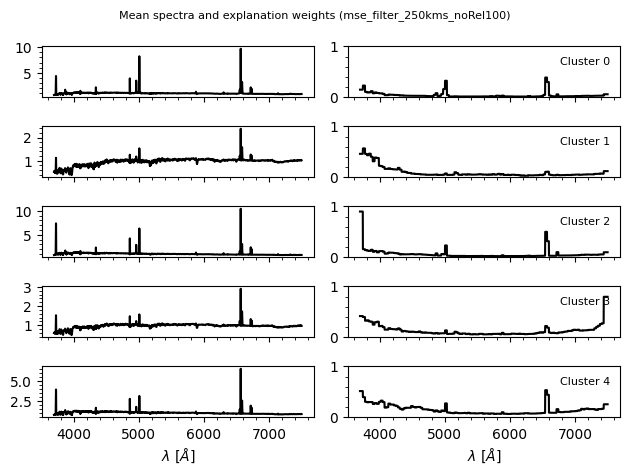

In [27]:
X = norm_abs_weights

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()

print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=True
)

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    avg_weights = cluster_weights.mean(axis=0)
    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 1].legend(
        [f"Cluster {label}"],
        fontsize=8,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 1].set_ylim(0., 1.)
# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
axs[4,1].set_xlabel("$\lambda$ [$\AA$]")
fig.suptitle(
    "Mean spectra and explanation weights "
    f"({score_name})",
    fontsize=8,
    # y=0.95
)
# axs[0].set_ylim(0., 1.)

# MSE filter 250 kms noRel97

In [ ]:
score_name = "mse_filter_250kms_noRel97"
explanation_run_id = "20250427105355_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)
norm_abs_weights = np.abs(weights)
norm_abs_weights /= np.max(norm_abs_weights, axis=1, keepdims=True)

<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:65: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_88216/3768913705.py:65: SyntaxWarning: invalid escape sequence '\l'
  axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_88216/3768913705.py:66: SyntaxWarning: invalid escape sequence '\l'
  axs[4,1].set_xlabel("$\lambda$ [$\AA$]")


train time: 0.94 seconds
Cluster: 0,N. spectra: 2677
Cluster: 1,N. spectra: 3254
Cluster: 2,N. spectra: 2153
Cluster: 3,N. spectra: 699
Cluster: 4,N. spectra: 1217


Text(0.5, 0.98, 'Mean spectra and explanation weights (mse_filter_250kms_noRel100)')

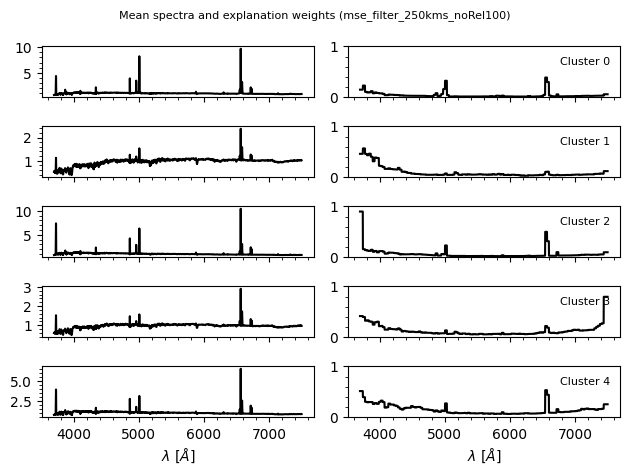

In [28]:
X = norm_abs_weights

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()

print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=True
)

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    avg_weights = cluster_weights.mean(axis=0)
    axs[label, 1].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 1].legend(
        [f"Cluster {label}"],
        fontsize=8,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 1].set_ylim(0., 1.)
# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
axs[4,1].set_xlabel("$\lambda$ [$\AA$]")
fig.suptitle(
    "Mean spectra and explanation weights "
    f"({score_name})",
    fontsize=8,
    # y=0.95
)
# axs[0].set_ylim(0., 1.)